Sample script for MNLab2BICN.

メディアネットワーク実験IIB 項目Iで利用するサンプル．

PSK および QAM は適切に実装されていません．`要修正`を要修正です．

必要なファイルを`github`から取り出す．

In [3]:
!test -d mnlab2bicn && (cd mnlab2bicn ; git pull) || git clone https://github.com/htsutsui/mnlab2bicn/
!cp mnlab2bicn/mnlab2bicn.py .
!cp mnlab2bicn/gray.py .

Cloning into 'mnlab2bicn'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 115 (delta 62), reused 76 (delta 36), pack-reused 0
Receiving objects: 100% (115/115), 28.66 KiB | 9.55 MiB/s, done.
Resolving deltas: 100% (62/62), done.


`mnlab2bicn`が依存する`gmpy2` (BER計算を高速化する)をインストールする．
なお，`gmpy2`が無くてもBER計算は可能(若干遅くなる)なので，エラーが生じる場合は無視すること．

In [4]:
!sudo apt-get update
!sudo apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
!pip install gmpy2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

NumPy と Matplotlib を使うので`import`する．

In [5]:
import matplotlib.pyplot as plt
import numpy as np

実験で使用するあらかじめ用意されている関数を`import`する．

In [6]:
from mnlab2bicn import awgn, calc_ser, calc_ber, \
    int2gray, gray2int, scatter_plot

このscript中で利用するdebug用の変数．

In [7]:
verbose = True # True だと for loop の処理の状況(進み具合)が確認できる
verbose_awgn = False

PSKのシミュレーションを行う関数を定義する．

In [8]:
def psk_test(m_level, i_snr, i_size, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src

    # Start of 要修正
    y = np.exp(1j*np.pi*2/m_level*x)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    z = np.angle(y_noisy)
    z = z/(np.pi*2/m_level)
    z = z.round()
    z = np.array(z.round(), dtype='int')
    z = np.where(z<0, z+m_level, z)
    # End of 要修正

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

QAMのシミュレーションを行う関数を定義する．

In [9]:
def qam_test(m_level, i_snr, i_size, plot=False, gray=False):
    """QAM test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)
    k = int(np.log2(m_level))
    smax = 2 ** (k // 2) - 1

    yr = src >> (k // 2)
    yi = src & smax

    yr = int2gray(yr) if gray else yr
    yi = int2gray(yi) if gray else yi

    # Start of 要修正
    yr = (2 * yr) / smax - 1
    yi = (2 * yi) / smax - 1
    y = yr + (1j * yi)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"QAM_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    zr = (y_noisy.real + 1) / 2 * smax
    zi = (y_noisy.imag + 1) / 2 * smax
    zr = zr.round()
    zi = zi.round()
    zr = np.array(zr, dtype='int')
    zi = np.array(zi, dtype='int') 
    # End of 要修正

    zr = np.where(zr < 0, 0, zr)
    zr = np.where(zr > smax, smax, zr)
    zi = np.where(zi < 0, 0, zi)
    zi = np.where(zi > smax, smax, zi)

    zr = gray2int(zr) if gray else zr
    zi = gray2int(zi) if gray else zi

    dst = zr << (k // 2)
    dst += zi

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

グラフのフォントサイズを調整する．

In [10]:
plt.rcParams.update({'font.size': 16})

(0.0, 0.0)

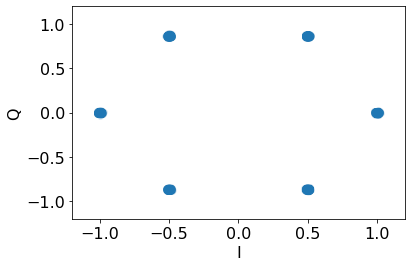

In [11]:
psk_test(6, 40, 20000, plot=True)

PSKのシミュレーションを行う．図は`PSK_4_30_100.png`および`PSK_4_30_100.pdf`に保存される．以下同様．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

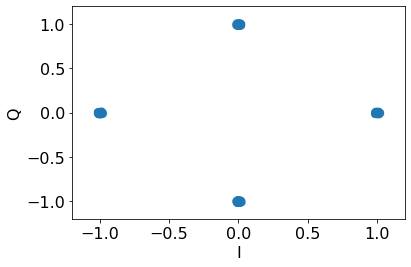

In [12]:
psk_test(4, 40, 20000, plot=True)

(0.0, 0.0)

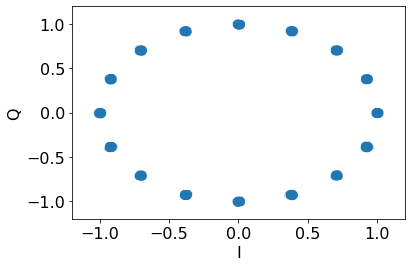

In [13]:
psk_test(16, 40, 20000, plot=True)

(0.0, 0.0)

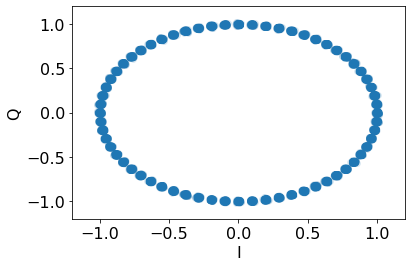

In [14]:
psk_test(64, 40, 20000, plot=True)

QAMのシミュレーションを行う．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

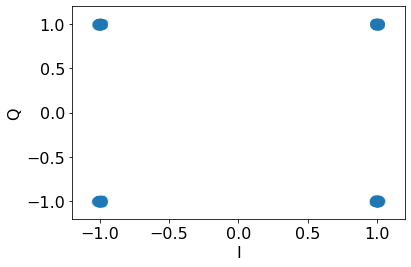

In [15]:
qam_test(4, 40, 20000, plot=True, gray=True)

(0.0, 0.0)

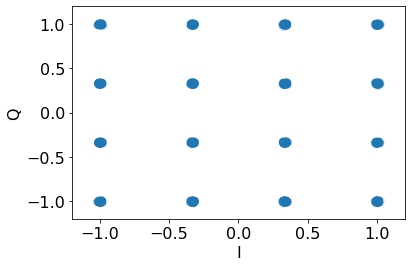

In [16]:
qam_test(16, 40, 20000, plot=True)

(0.0, 0.0)

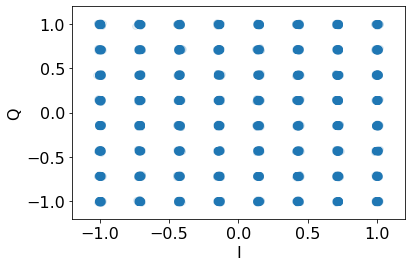

In [17]:
qam_test(64, 40, 20000, plot=True)

グラフのフォントサイズを調整する．

In [18]:
plt.rcParams.update({'font.size': 12})

PSK/QAM Comparison

課題3．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.944045, 0.42222583333333336]
[2, 64, 0.93041, 0.40222833333333335]
[4, 64, 0.911955, 0.37823]
[6, 64, 0.890515, 0.35434]
[8, 64, 0.86199, 0.32827416666666664]
[10, 64, 0.826505, 0.30341]
[12, 64, 0.781155, 0.2751458333333333]
[14, 64, 0.72764, 0.24852666666666667]
[16, 64, 0.66302, 0.22160083333333333]
[18, 64, 0.5814, 0.19130833333333333]
[20, 64, 0.4861, 0.15935166666666667]
[22, 64, 0.38303, 0.12563333333333335]
[24, 64, 0.27069, 0.088705]
[26, 64, 0.165845, 0.05414666666666667]
[28, 64, 0.079965, 0.026183333333333333]
[30, 64, 0.027875, 0.009085833333333333]
[32, 64, 0.00576, 0.0018608333333333333]
[34, 64, 0.00051, 0.00015583333333333334]
[36, 64, 1.5e-05, 7.5e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.92236, 0.36306333333333335]
[2, 64, 0.900945, 0.3442225]
[4, 64, 0.86897, 0.32077666666666665]
[6, 64, 0.82395, 0.29294916666666665]
[8, 64, 0.759855, 0.2600225]
[10, 64, 0.674265, 0.22137833333333334]
[12, 64, 0.56046, 0.17578666666666667]
[14, 64, 0.42208, 0.12543083333333332]
[1

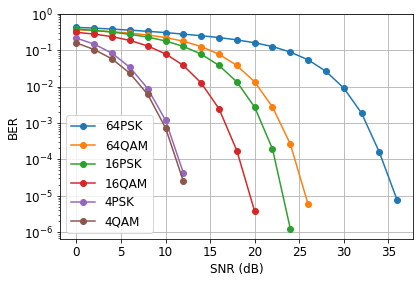

In [19]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_QAM.png")
plt.savefig("PSK_QAM.pdf")

PSK Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.94403, 0.421589]
[2, 64, 0.9295, 0.40139633333333335]
[4, 64, 0.91242, 0.3780676666666667]
[6, 64, 0.890308, 0.35482433333333335]
[8, 64, 0.862114, 0.328938]
[10, 64, 0.826632, 0.302654]
[12, 64, 0.783004, 0.2760533333333333]
[14, 64, 0.727096, 0.24842]
[16, 64, 0.660724, 0.220395]
[18, 64, 0.5809, 0.190802]
[20, 64, 0.489642, 0.16075166666666665]
[22, 64, 0.382416, 0.125584]
[24, 64, 0.272192, 0.08921366666666666]
[26, 64, 0.16615, 0.05456933333333333]
[28, 64, 0.080996, 0.026417333333333334]
[30, 64, 0.028472, 0.009407333333333334]
[32, 64, 0.005654, 0.0018903333333333333]
[34, 64, 0.000522, 0.00018]
[36, 64, 2.2e-05, 5.666666666666667e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.943326, 0.3815093333333333]
[2, 64, 0.930308, 0.3576316666666667]
[4, 64, 0.91174, 0.331511]
[6, 64, 0.890026, 0.3039386666666667]
[8, 64, 0.861506, 0.27591]
[10, 64, 0.826112, 0.24822566666666668]
[12, 64, 0.78289, 0.22116166666666667]
[14, 64, 0.726866, 0.193667]
[16, 64, 0.660178, 0.16593233333333332]
[18,

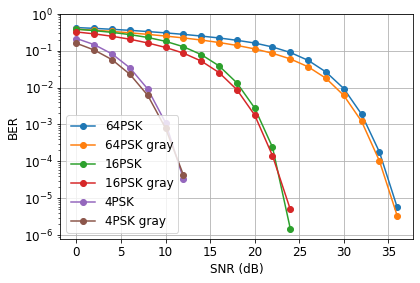

In [20]:
size = 500000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_gray.png")
plt.savefig("PSK_gray.pdf")

QAM Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.92361, 0.36362]
[2, 64, 0.89989, 0.3433758333333333]
[4, 64, 0.869655, 0.32042]
[6, 64, 0.82519, 0.2931283333333333]
[8, 64, 0.76099, 0.26008416666666667]
[10, 64, 0.6752, 0.2219525]
[12, 64, 0.560015, 0.1757525]
[14, 64, 0.42217, 0.12541333333333332]
[16, 64, 0.273925, 0.07733666666666666]
[18, 64, 0.13903, 0.03776583333333333]
[20, 64, 0.05084, 0.0135175]
[22, 64, 0.01061, 0.002778333333333333]
[24, 64, 0.001045, 0.0002775]
[26, 64, 2e-05, 5.833333333333333e-06]
[28, 64, 0.0, 0.0]
[0, 64, 0.92421, 0.35825833333333335]
[2, 64, 0.902115, 0.3221133333333333]
[4, 64, 0.868485, 0.2833175]
[6, 64, 0.824535, 0.2454325]
[8, 64, 0.761175, 0.20692333333333332]
[10, 64, 0.67273, 0.16787583333333334]
[12, 64, 0.560175, 0.1295425]
[14, 64, 0.422325, 0.09149916666666667]
[16, 64, 0.275495, 0.05648416666666667]
[18, 64, 0.14064, 0.0278425]
[20, 64, 0.04901, 0.0094925]
[22, 64, 0.011, 0.0020933333333333333]
[24, 64, 0.00105, 0.00019666666666666666]
[26, 64, 2e-05, 4.166666666666667e-06]
[2

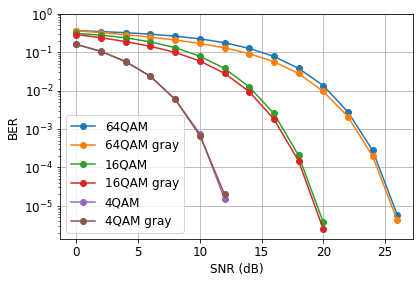

In [21]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("QAM_gray.png")
plt.savefig("QAM_gray.pdf")

## I)PSKで6角形に配置してみます

(0.0, 0.0)

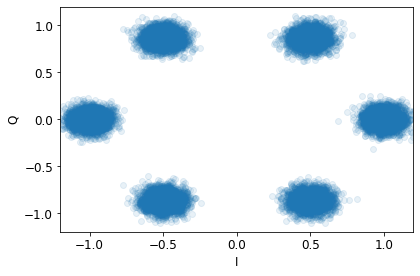

In [22]:
psk_test(m_level = 6, i_snr = 20, i_size = 20000, plot=True)

### 信号が6角形になっているのが分かると思います．
### この6PSKの性能をほかのPSKと比べてみましょう,SNR-BERプロットを行ってみます．

[0, 64, 0.94363, 0.421774]
[2, 64, 0.929678, 0.4018273333333333]
[4, 64, 0.91241, 0.378847]
[6, 64, 0.88954, 0.353629]
[8, 64, 0.86072, 0.32800033333333334]
[10, 64, 0.827496, 0.30264233333333335]
[12, 64, 0.78142, 0.27584233333333336]
[14, 64, 0.72912, 0.24919366666666667]
[16, 64, 0.661898, 0.220628]
[18, 64, 0.581692, 0.19120466666666666]
[20, 64, 0.487846, 0.15997133333333333]
[22, 64, 0.383108, 0.12559466666666666]
[24, 64, 0.271422, 0.08910566666666667]
[26, 64, 0.166524, 0.054616]
[28, 64, 0.082018, 0.026938333333333335]
[30, 64, 0.028206, 0.009333333333333334]
[32, 64, 0.005912, 0.001971]
[34, 64, 0.00049, 0.00015133333333333334]
[36, 64, 1.8e-05, 5.333333333333334e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.943406, 0.3810926666666667]
[2, 64, 0.930054, 0.35786633333333334]
[4, 64, 0.912522, 0.33160233333333333]
[6, 64, 0.890514, 0.3037803333333333]
[8, 64, 0.861122, 0.27588966666666664]
[10, 64, 0.826004, 0.24858366666666667]
[12, 64, 0.781968, 0.22137433333333334]
[14, 64, 0.72784, 0.1

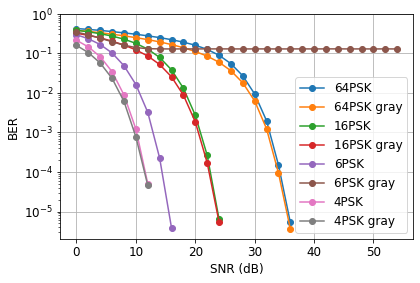

In [23]:
size = 500000
for m in [64, 16, 6, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_gray_.png")
plt.savefig("PSK_gray_.pdf")

## I)6PSKについて以上です．

## II)らせん状シフトキーイング
### その名もArchimedes Shift Keyingです．
情報信号$x$を位相シフトと振幅シフトを行い
$$y = r(x) e^{j \theta(x)}$$とします． <br>
ここで位相シフト$r(x)$と振幅シフト$\theta(x)$は$x$によって決まり，基本となる数式は以下で表現されます<br>

$$
\theta = \Delta \theta  \cdot x\\
r = a \theta \\
 \\
\Delta \theta = \frac{2.0 \pi}{回転数} \cdot \frac{1}{配置信号数}
$$

なお，$a$は振幅$r$の最大値が$1.0$になるように正規化するための定数です．

In [27]:
import math

def ask_test(m_level, i_snr, i_size, rotation_num = 2, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    a: r = a * theta
    rotation_num: くるくる回転する回数
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src


    # Start of 要修正
    #y = np.exp(1j*np.pi*2/m_level*x)
    # End of 要修正
    """
    2.0 * np.pi * (rotation_num + 1) * a= 1.0
    <-> a = 1.0 / (2.0 * np.pi * (rotation_num + 1))
    """

    a = 1.0 / (2.0 * np.pi * (rotation_num + 1))

    """
    xに位相シフトと振幅シフトを適用させる
    y = r * exp(j theta x)
    r = a * theta
    """

    #Shift Start
    d_theta = np.pi*2/m_level * rotation_num

    theta = d_theta * x + (2.0 * np.pi) * 1.0
    r = a * theta
    y = r * np.exp(1j*theta)
    #Shift End

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of PSK Decryption
    """ 
    z = np.angle(y_noisy)
    z = z/(np.pi*2/m_level)
    z = z.round()
    z = np.array(z.round(), dtype='int')
    z = np.where(z<0, z+m_level, z)
    """
    # End of PSK Decryption

    # Start of ASK Decryption
    z = np.abs(y) # z = r
    z = (z/a - 2.0 * np.pi) / d_theta
    # End of ASK Decryption

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

#### 複号技術
我々の目的は変調した信号$y$にGauss雑音$\epsilon$が乗った$\hat{y} = y + \epsilon$から$x$を複号することです．受信側は$\hat{y}$しか観測できていないことに注意しましょう．
$$
  \hat{y} = \hat{r} e^{j \hat{\theta}}
$$
とおき，今回のアルゴリズムは振幅$\hat{r}$から情報信号$x$を復号してみることにします．<br>
上式より
$$
\hat{r} = |\hat{y}|
$$
と絶対値をとることで求められます．<br>
また，変調$r = a \theta  , (\theta = \Delta \theta \cdot x)$を思い出しましょう．いま，$\hat{r}$をとりだしたので，情報信号$x$は以下のように予測することができます．
$$
\hat{x} = \frac{\hat{r}}{a} \cdot \frac{1}{\Delta \theta }
$$

### 信号配置を見てみましょう

(0.33615, 0.09339166666666666)

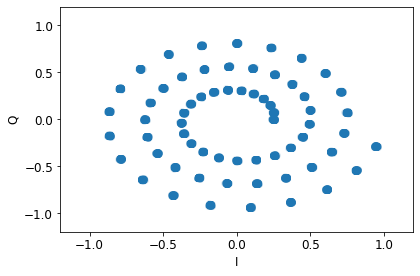

In [25]:
ask_test(m_level = 64, i_snr = 40, i_size = 20000, rotation_num = 3, plot=True)

(0.3123, 0.109525)

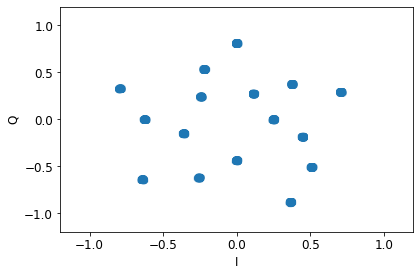

In [29]:
ask_test(m_level = 16, i_snr = 40, i_size = 20000, rotation_num = 3, plot=True)

(0.0, 0.0)

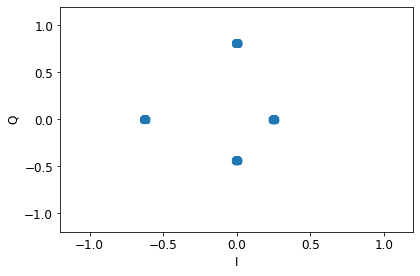

In [30]:
ask_test(m_level = 4, i_snr = 40, i_size = 20000, rotation_num = 3, plot=True)

### Archimedesの螺旋になっていることが分かると思います．

### 普通のPSKに対してSNR-BERグラフをプロットしてみましょう．

[0, 64, 0.943345, 0.42210333333333333]
[2, 64, 0.930085, 0.40119166666666667]
[4, 64, 0.91313, 0.37940416666666665]
[6, 64, 0.890105, 0.35469]
[8, 64, 0.861395, 0.32889666666666667]
[10, 64, 0.826075, 0.30254333333333333]
[12, 64, 0.782845, 0.27547333333333335]
[14, 64, 0.728335, 0.24823666666666666]
[16, 64, 0.663055, 0.221515]
[18, 64, 0.57893, 0.19027666666666668]
[20, 64, 0.48868, 0.160275]
[22, 64, 0.381855, 0.12573666666666666]
[24, 64, 0.271455, 0.08889583333333333]
[26, 64, 0.16693, 0.05487416666666667]
[28, 64, 0.08239, 0.027075833333333334]
[30, 64, 0.028455, 0.009370833333333333]
[32, 64, 0.00572, 0.0018791666666666666]
[34, 64, 0.0005, 0.00017083333333333333]
[36, 64, 1e-05, 5e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.92367, 0.363535]
[2, 64, 0.901895, 0.34383833333333336]
[4, 64, 0.86926, 0.3193825]
[6, 64, 0.825395, 0.29321]
[8, 64, 0.75883, 0.25966083333333334]
[10, 64, 0.673795, 0.22173416666666668]
[12, 64, 0.561565, 0.17592666666666668]
[14, 64, 0.421675, 0.12523083333333335]

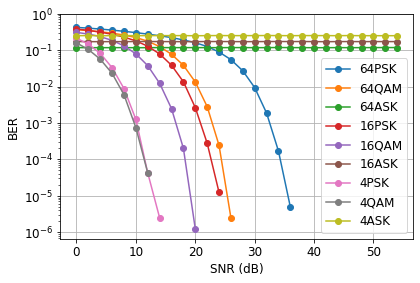

In [28]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")

    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")

    #ASK
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = ask_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}ASK")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_QAM_ASK.png")
plt.savefig("PSK_QAM_ASK.pdf")